# Fingerprint distances between structures for the same kinase

In this notebook, we investigate the ranges of fingerprint distances for each kinase pair.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_local

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_local(HERE / "../../data/external/20210114_KLIFS_HUMAN/")
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = (
    DATA / "fingerprint_distances.csv"
)

In [9]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)

In [10]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 292
Number of structures: 4916


In [11]:
structure_distances = fingerprint_distance_generator.data
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,3835,6679,AAK1,AAK1,0.051608,0.992667
1,3835,7156,AAK1,AAK1,0.059276,0.991333
2,3835,1104,AAK1,ABL1,0.275259,0.990667
3,3835,1065,AAK1,ABL1,0.284854,0.990667
4,3835,1090,AAK1,ABL1,0.262851,0.990667


### Add DFG conformation

In [12]:
%%time
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: dfg[x])
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: dfg[x])

CPU times: user 1min 2s, sys: 400 ms, total: 1min 2s
Wall time: 1min 2s


### Filter distances by coverage cutoff

In [13]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2,distance_filtered
0,3835,6679,AAK1,AAK1,0.051608,0.992667,in,in,0.051608
1,3835,7156,AAK1,AAK1,0.059276,0.991333,in,in,0.059276
2,3835,1104,AAK1,ABL1,0.275259,0.990667,in,out-like,0.275259
3,3835,1065,AAK1,ABL1,0.284854,0.990667,in,out,0.284854
4,3835,1090,AAK1,ABL1,0.262851,0.990667,in,in,0.262851


In [14]:
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]

In [15]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 12081070
Structure pairs not-NaN: 11964546


## Structure distances

### Structure distance distributions for different subsets

- All structure distances
- Structure distances between the same kinases
- Structure distances between different kinases

#### Without coverage cutoff

In [16]:
structure_distances_df = pd.DataFrame(
    {
        "all": structure_distances["distance"],
        "intra-kinase": structure_distances[
            structure_distances["kinase.1"] == structure_distances["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances[
            ~(structure_distances["kinase.1"] == structure_distances["kinase.2"])
        ]["distance"],
    }
)

In [17]:
structure_distances_df.notna().sum()

all             12081070
intra-kinase      246276
inter-kinase    11834794
dtype: int64

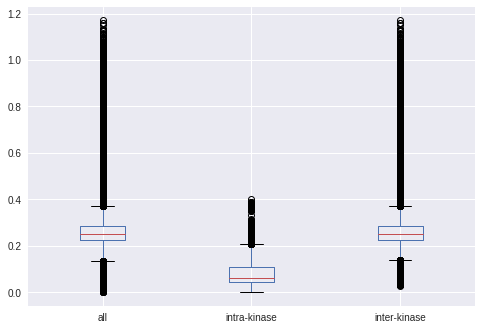

In [18]:
structure_distances_df.plot(kind="box");

In [19]:
structure_distances_df.describe()

,all,intra-kinase,inter-kinase
count,1.208107e+07,246276.000000,1.183479e+07
mean,2.602043e-01,0.076376,2.640297e-01
std,6.641477e-02,0.041927,6.122325e-02
min,0.000000e+00,0.000000,2.750373e-02
25%,2.248570e-01,0.043636,2.266979e-01
50%,2.513172e-01,0.062312,2.523743e-01
75%,2.842624e-01,0.109751,2.852527e-01
max,1.170402e+00,0.402767,1.170402e+00


#### With coverage cutoff

In [20]:
structure_distances_filtered_df = pd.DataFrame(
    {
        "all": structure_distances_filtered["distance"],
        "intra-kinase": structure_distances_filtered[
            structure_distances_filtered["kinase.1"] == structure_distances_filtered["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances_filtered[
            ~(structure_distances_filtered["kinase.1"] == structure_distances_filtered["kinase.2"])
        ]["distance"],
    }
)

In [21]:
structure_distances_filtered_df.notna().sum()

all             11964546
intra-kinase      245711
inter-kinase    11718835
dtype: int64

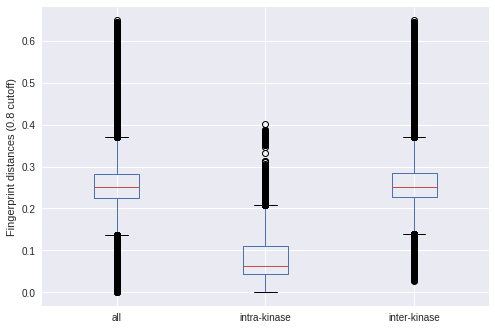

In [22]:
fig, axes = plt.subplots(1, 1)
structure_distances_filtered_df.plot(kind="box", ax=axes)
axes.set_ylabel(f"Fingerprint distances ({COVERAGE_CUTOFF} cutoff)");

In [23]:
structure_distances_filtered_df.describe()

,all,intra-kinase,inter-kinase
count,1.196455e+07,245711.000000,1.171884e+07
mean,2.591149e-01,0.076273,2.629486e-01
std,6.416281e-02,0.041891,5.874299e-02
min,0.000000e+00,0.000000,2.750373e-02
25%,2.246006e-01,0.043598,2.264521e-01
50%,2.509275e-01,0.062209,2.519808e-01
75%,2.833567e-01,0.109519,2.843347e-01
max,6.492761e-01,0.402767,6.492761e-01


### Per kinase distributions

How robust are structure distances within kinase pairs?

#### All kinase pairs

In [25]:
data = structure_distances_filtered[["kinase.1", "kinase.2", "distance"]].groupby(
    ["kinase.1", "kinase.2"]
)

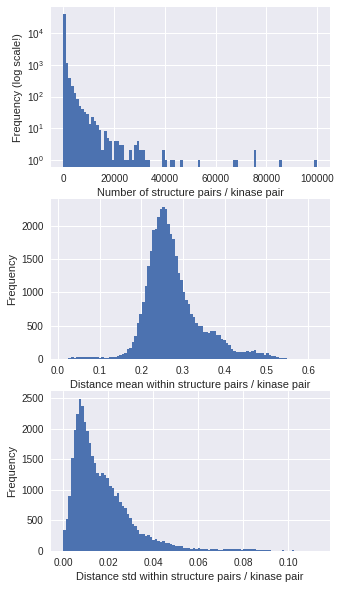

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
# Size
data.size().plot(ax=axes[0], kind="hist", logy=True, style=".", bins=100)
axes[0].set_xlabel("Number of structure pairs / kinase pair")
axes[0].set_ylabel("Frequency (log scale!)")
# Mean
data.mean().squeeze().plot(ax=axes[1], kind="hist", style=".", bins=100)
axes[1].set_xlabel("Distance mean within structure pairs / kinase pair")
# Std
data.std().squeeze().plot(ax=axes[2], kind="hist", logy=False, style=".", bins=100)
axes[2].set_xlabel("Distance std within structure pairs / kinase pair");

In [27]:
print("size == 1: ", data.size()[data.size() == 1].shape[0])
print("size < 5: ", data.size()[data.size() < 5].shape[0])
print("size < 10: ", data.size()[data.size() < 10].shape[0])
print("size < 100: ", data.size()[data.size() < 100].shape[0])
print("size < 1000: ", data.size()[data.size() < 1000].shape[0])
print("size < 10000: ", data.size()[data.size() < 10000].shape[0])
print("size: ", data.size().shape[0])

size == 1:  1809
size < 5:  7516
size < 10:  12389
size < 100:  29840
size < 1000:  39301
size < 10000:  41367
size:  41507


In [28]:
data.mean().describe()

,distance
count,41507.000000
mean,0.275824
std,0.067315
min,0.013405
25%,0.234260
50%,0.262906
75%,0.303612
max,0.621157


In [29]:
data.std().describe()

,distance
count,3.969800e+04
mean,1.728075e-02
std,1.350195e-02
min,3.961060e-07
25%,7.875723e-03
50%,1.361693e-02
75%,2.288679e-02
max,1.128298e-01


#### Most frequent kinase pairs (all conformations)

In [30]:
data = structure_distances_filtered.groupby(["kinase.1", "kinase.2"])

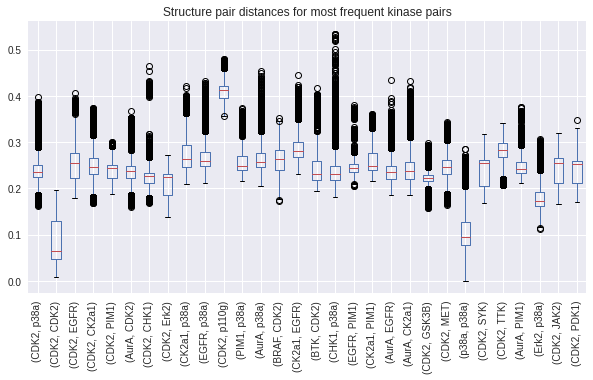

In [31]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

In [32]:
data_min = data.min()

In [34]:
print("Minimum pair has same conformations")
print(data_min[data_min["dfg.1"] == data_min["dfg.2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has same conformations
82.50415592550654


In [35]:
print("Minimum pair has different conformations")
print(data_min[data_min["dfg.1"] != data_min["dfg.2"]].shape[0] / data_min.shape[0] * 100)

Minimum pair has different conformations
17.49584407449346


#### Most frequent kinase pairs (DFG-in conformations only)

In [36]:
structure_distances_filtered_dfgin = structure_distances_filtered[
    (structure_distances_filtered["dfg.1"] == "in")
    & (structure_distances_filtered["dfg.2"] == "in")
]
structure_distances_filtered.shape, structure_distances_filtered_dfgin.shape

((11964546, 9), (8986558, 9))

In [37]:
data = structure_distances_filtered_dfgin.groupby(["kinase.1", "kinase.2"])

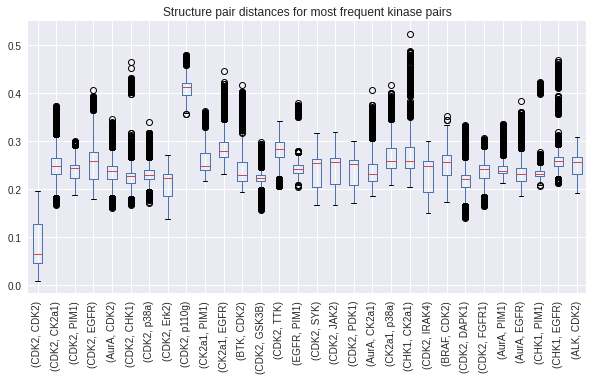

In [38]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

## Structure > kinase distances (median)

In [39]:
kinase_distances = structure_distances.groupby(["kinase.1", "kinase.2"]).median().reset_index()
kinase_distances.head()

,kinase.1,kinase.2,structure.1,structure.2,distance,bit_coverage,distance_filtered
0,AAK1,AAK1,3835.0,7156.0,0.051608,0.992667,0.051608
1,AAK1,ABL1,6679.0,1085.0,0.269687,0.990667,0.269687
2,AAK1,ABL2,6679.0,115.0,0.273110,0.990000,0.273110
3,AAK1,ACK,6679.0,3406.5,0.261100,0.990000,0.261100
4,AAK1,ACTR2,6679.0,2679.0,0.269498,0.990667,0.269498


In [40]:
kinase_distances_filtered = kinase_distances[kinase_distances["distance_filtered"].notna()]

In [41]:
print(f"Kinase pairs: {kinase_distances.shape[0]}")
print(f"Kinase pairs not-NaN: {kinase_distances_filtered.shape[0]}")

Kinase pairs: 42717
Kinase pairs not-NaN: 41507


## Kinase matrix

### All distances

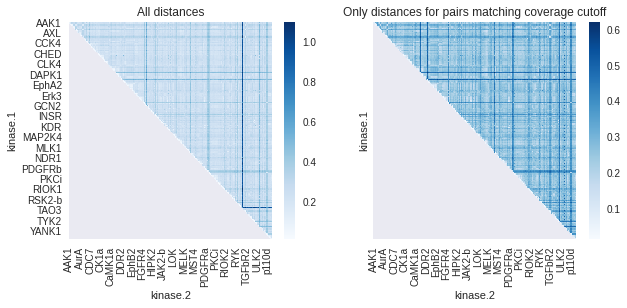

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("All distances")
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance_filtered")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Only distances for pairs matching coverage cutoff");

In [43]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [44]:
n_structures = (
    pd.concat([structure_distances["structure.1"], structure_distances["structure.2"]])
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat([structure_distances["kinase.1"], structure_distances["kinase.2"]]).unique().shape[0]
)
n_structures_filtered = (
    pd.concat(
        [structure_distances_filtered["structure.1"], structure_distances_filtered["structure.2"]]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat([structure_distances_filtered["kinase.1"], structure_distances_filtered["kinase.2"]])
    .unique()
    .shape[0]
)


table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        kinase_distances.shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        kinase_distances_filtered.shape[0],
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

,All distances,Only distances matching cutoff
Number of structures,4916,4897
Number of structure pairs (theory),12085986,11992753
Number of structure pairs (experimental),12081070,11964546
Number of kinases,292,288
Number of kinase pairs (theory),42778,41616
Number of kinase pairs (experimental),42717,41507


## Dual kinases paper dataset

https://www.mdpi.com/1420-3049/26/3/629

In [45]:
from itertools import combinations_with_replacement

In [46]:
KINASES_KLIFS_TO_PAPER = {
    "EGFR": "EGFR",
    "ErbB2": "ErbB2",
    "KDR": "VEGFR2",
    "p110a": "PI3K",
    "BRAF": "BRAF",
    "CDK2": "CDK2",
    "LCK": "LCK",
    "MET": "MET",
    "p38a": "p38a",
}

In [47]:
example_kinases = list(KINASES_KLIFS_TO_PAPER.keys())
print(example_kinases)
example_kinase_pairs = [i for i in combinations_with_replacement(example_kinases, 2)]

['EGFR', 'ErbB2', 'KDR', 'p110a', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']


In [48]:
example_kinase_distances = kinase_distances_filtered[
    kinase_distances_filtered.apply(
        lambda x: (x["kinase.1"], x["kinase.2"]) in example_kinase_pairs, axis=1
    )
]

In [49]:
example_kinase_distances.shape

(35, 7)

In [50]:
example_kinase_matrix = example_kinase_distances.pivot("kinase.1", "kinase.2", "distance")
example_kinase_matrix = example_kinase_matrix.loc[example_kinases, example_kinases]
example_kinase_matrix

kinase.2,EGFR,ErbB2,KDR,p110a,BRAF,CDK2,LCK,MET,p38a
kinase.1,,,,,,,,,
EGFR,0.085393,0.152305,0.198817,0.390376,NaN,NaN,0.200213,0.234168,0.260284
ErbB2,NaN,0.131087,0.242638,0.382840,NaN,NaN,0.258612,0.245468,0.286683
KDR,NaN,NaN,0.063191,0.396491,NaN,NaN,0.203631,0.206863,0.240895
p110a,NaN,NaN,NaN,0.051344,NaN,NaN,NaN,NaN,0.396006
BRAF,NaN,NaN,NaN,NaN,0.105909,0.264240,0.247116,0.262823,0.275735
CDK2,NaN,NaN,NaN,NaN,NaN,0.065616,0.250620,0.245666,0.234746
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.038409,0.238275,0.250528
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095704,0.277871
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095770


In [51]:
example_kinase_matrix.columns = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.columns]
example_kinase_matrix.index = [KINASES_KLIFS_TO_PAPER[i] for i in example_kinase_matrix.index]
example_kinase_matrix

,EGFR,ErbB2,VEGFR2,PI3K,BRAF,CDK2,LCK,MET,p38a
EGFR,0.085393,0.152305,0.198817,0.390376,NaN,NaN,0.200213,0.234168,0.260284
ErbB2,NaN,0.131087,0.242638,0.382840,NaN,NaN,0.258612,0.245468,0.286683
VEGFR2,NaN,NaN,0.063191,0.396491,NaN,NaN,0.203631,0.206863,0.240895
PI3K,NaN,NaN,NaN,0.051344,NaN,NaN,NaN,NaN,0.396006
BRAF,NaN,NaN,NaN,NaN,0.105909,0.264240,0.247116,0.262823,0.275735
CDK2,NaN,NaN,NaN,NaN,NaN,0.065616,0.250620,0.245666,0.234746
LCK,NaN,NaN,NaN,NaN,NaN,NaN,0.038409,0.238275,0.250528
MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095704,0.277871
p38a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095770


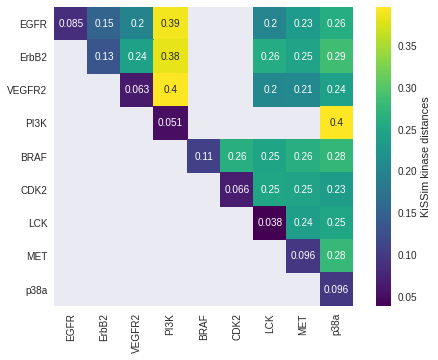

In [52]:
sns.heatmap(
    example_kinase_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "KiSSim kinase distances"},
    cmap="viridis",
)
plt.show()

Compare to paper (shows similarities; not distances; __so think values inverse__):

![](https://www.mdpi.com/molecules/molecules-26-00629/article_deploy/html/images/molecules-26-00629-g002.png)

Figure 2. Heat maps of pairwise kinase similarities for the different measures used in this work: (A) ligand profile similarity (LigProfSim); (B) pocket sequence similarity (PocSeqSim); (C) interaction fingerprint similarity (IFPSim); (D) pocket structure similarity (PocStrucSim); and (E) docking rank similarity (DockRankSim) based on the lead-like subset of ZINC. Note that docking was only performed for the five kinases of Profiles 1–4, thus the remaining entries remain empty (white) in the matrix.